<a href="https://colab.research.google.com/github/nsharma73/capstone_haystack/blob/main/Capstone_Project_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project - GA Real Estate - Clustering**

*By Liliya Lopez*

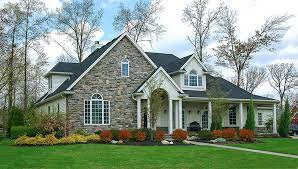

## **1.Introduction**

#####**Libraries used**

In [50]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt 
import seaborn as sns 
import io
import json
import descartes
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import folium

##### **Import datasets**

In [52]:
from google.colab import drive

In [53]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
completed_data = pd.read_csv('drive/MyDrive/Colab Notebooks/zillow_schools_tax_dataV2.csv', index_col=0)
pd.set_option('display.max_columns', 20)
completed_data.reset_index(inplace=True)
completed_data.head()

,rentZestimate,zestimate,price_y,PCT_CHG,bathrooms,bedrooms,yearBuilt,address,city,state,...,other_crime_total_rate,Prop_Cond_Grp_New,Prop_Cond_Grp_Remodeled,Prop_Cond_Grp_Resale,Two_Car_Garage_0,Two_Car_Garage_1,HasPool_0,HasPool_1,HasHardwood_0,HasHardwood_1
0,2177.90,347870.00,339900,0.117940,2,4,2020.0,101 College Street,Kingsland,Georgia,...,6.365,0,0,1,0,1,1,0,1,0
1,2600.00,325200.00,310000,0.113899,3,5,2004.0,169 School House Creek Drive,Saint Marys,Georgia,...,6.815,0,0,1,1,0,1,0,1,0
2,1999.00,340500.00,315000,0.113899,2,3,2004.0,1621 Sandpiper Court,Saint Marys,Georgia,...,6.815,0,0,1,0,1,1,0,1,0
3,1999.00,312758.00,310000,0.117940,2,3,2018.0,346 Laurel Landing Boulevard,Kingsland,Georgia,...,6.365,0,0,1,1,0,1,0,1,0
4,1980.45,362160.13,369900,0.020674,2,3,2022.0,81 Ossabaw Way,Waverly,Georgia,...,7.125,1,0,0,0,1,1,0,1,0


In [55]:
sum(completed_data.duplicated())

0

In [56]:
completed_data.isnull().sum(axis=0)

rentZestimate                0
zestimate                    0
price_y                      0
PCT_CHG                      0
bathrooms                    0
bedrooms                     0
yearBuilt                    0
address                      0
city                         0
state                        0
zip                          0
latitude                     0
longitude                    0
livingArea                   0
Lot_Size_SqFt                0
Price_SqFt                   0
cap_rate                     0
Tot_Appl                     0
Tot_Comm_Feat                0
Page_Views                   0
Sch_Rat_Avg                  0
Sch_Dist_Avg                 0
sch_cnt                      0
Individuals_taxed            0
Income_per_return            0
Cap_gain                     0
Pension                      0
UE_claims                    0
Social_security              0
SB_income                    0
Student_loan_ded             0
RE_taxes                     0
PP_taxes

In [57]:
completed_data.shape

(4591, 47)

In [58]:
completed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4591 entries, 0 to 4590
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   rentZestimate              4591 non-null   float64
 1   zestimate                  4591 non-null   float64
 2   price_y                    4591 non-null   int64  
 3   PCT_CHG                    4591 non-null   float64
 4   bathrooms                  4591 non-null   int64  
 5   bedrooms                   4591 non-null   int64  
 6   yearBuilt                  4591 non-null   float64
 7   address                    4591 non-null   object 
 8   city                       4591 non-null   object 
 9   state                      4591 non-null   object 
 10  zip                        4591 non-null   int64  
 11  latitude                   4591 non-null   float64
 12  longitude                  4591 non-null   float64
 13  livingArea                 4591 non-null   float

In [59]:
georgia_map = gpd.read_file('drive/MyDrive/Colab Notebooks/Georgia_State_Boundary/Georgia_State_Boundary.shp')

## **2.Exploratory Data Analysis**

#####**Distribution of numeric features**

In [60]:
num_features = completed_data.select_dtypes(include=['int64','float64'])
num_features.head()

,rentZestimate,zestimate,price_y,PCT_CHG,bathrooms,bedrooms,yearBuilt,zip,latitude,longitude,...,other_crime_total_rate,Prop_Cond_Grp_New,Prop_Cond_Grp_Remodeled,Prop_Cond_Grp_Resale,Two_Car_Garage_0,Two_Car_Garage_1,HasPool_0,HasPool_1,HasHardwood_0,HasHardwood_1
0,2177.90,347870.00,339900,0.117940,2,4,2020.0,31548,30.804209,-81.653325,...,6.365,0,0,1,0,1,1,0,1,0
1,2600.00,325200.00,310000,0.113899,3,5,2004.0,31558,30.767365,-81.588272,...,6.815,0,0,1,1,0,1,0,1,0
2,1999.00,340500.00,315000,0.113899,2,3,2004.0,31558,30.746731,-81.633995,...,6.815,0,0,1,0,1,1,0,1,0
3,1999.00,312758.00,310000,0.117940,2,3,2018.0,31548,30.791878,-81.676750,...,6.365,0,0,1,1,0,1,0,1,0
4,1980.45,362160.13,369900,0.020674,2,3,2022.0,31565,31.104492,-81.604486,...,7.125,1,0,0,0,1,1,0,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2cd997190>,
      dtype=object)

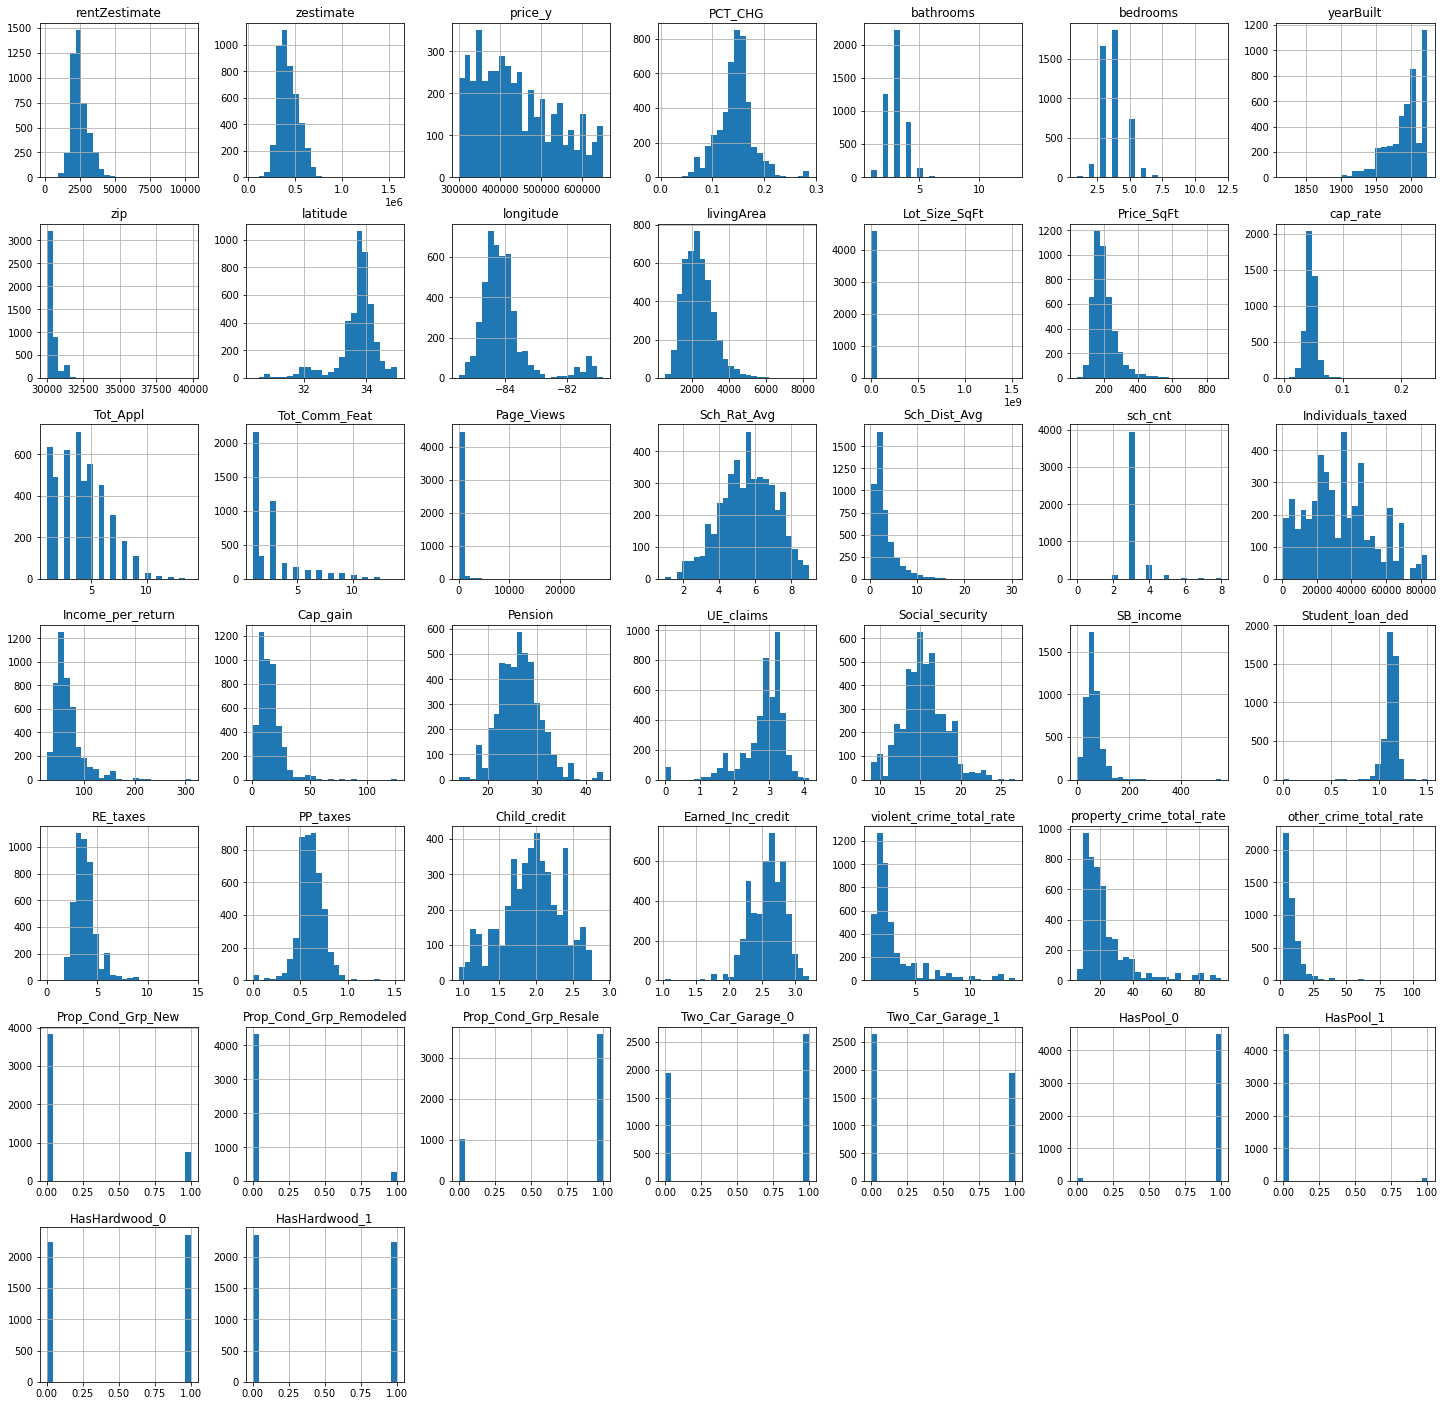

In [61]:
num_features.hist(bins=25, figsize=(25,25))

#####**Correlarion Matrix**

In [62]:
completed_data.corr().style.background_gradient()

,rentZestimate,zestimate,price_y,PCT_CHG,bathrooms,bedrooms,yearBuilt,zip,latitude,longitude,livingArea,Lot_Size_SqFt,Price_SqFt,cap_rate,Tot_Appl,Tot_Comm_Feat,Page_Views,Sch_Rat_Avg,Sch_Dist_Avg,sch_cnt,Individuals_taxed,Income_per_return,Cap_gain,Pension,UE_claims,Social_security,SB_income,Student_loan_ded,RE_taxes,PP_taxes,Child_credit,Earned_Inc_credit,violent_crime_total_rate,property_crime_total_rate,other_crime_total_rate,Prop_Cond_Grp_New,Prop_Cond_Grp_Remodeled,Prop_Cond_Grp_Resale,Two_Car_Garage_0,Two_Car_Garage_1,HasPool_0,HasPool_1,HasHardwood_0,HasHardwood_1
rentZestimate,1.000000,0.778080,0.643172,-0.124201,0.478812,0.399900,0.162927,0.019969,-0.043347,0.025603,0.558376,0.023387,-0.182282,0.504133,0.218560,0.176394,0.015017,0.137967,-0.021400,-0.058387,0.040142,0.247971,0.191897,0.163136,0.111338,0.217863,0.176684,0.041986,0.248560,-0.021538,0.160809,-0.158701,-0.079268,-0.061166,-0.029596,0.089661,-0.037327,-0.059622,-0.097371,0.097371,-0.067811,0.067811,-0.199091,0.199091
zestimate,0.778080,1.000000,0.797569,-0.112739,0.402213,0.277827,0.224048,-0.040761,0.066861,-0.009065,0.480457,0.025222,-0.009443,0.017224,0.279296,0.270018,-0.018892,0.249860,-0.029005,-0.051604,0.098856,0.321832,0.226820,0.194754,0.124106,0.296317,0.199908,0.027651,0.303871,-0.067421,0.254191,-0.254368,-0.134823,-0.105142,-0.055949,0.143442,-0.012021,-0.121757,-0.152027,0.152027,-0.069784,0.069784,-0.262902,0.262902
price_y,0.643172,0.797569,1.000000,-0.100800,0.386751,0.252054,0.121350,-0.013356,0.086269,-0.010907,0.485885,0.020268,0.153898,-0.294415,0.230993,0.234126,0.023061,0.198113,0.052898,-0.040206,0.010508,0.278166,0.221205,0.207823,0.025562,0.274066,0.179005,-0.015348,0.265619,-0.129091,0.206416,-0.223936,-0.095964,-0.071609,-0.029474,0.098201,-0.026349,-0.073336,-0.054117,0.054117,-0.058773,0.058773,-0.208336,0.208336
PCT_CHG,-0.124201,-0.112739,-0.100800,1.000000,0.016153,0.028251,0.081058,-0.263504,0.271235,-0.243635,0.003162,0.013587,-0.090279,-0.044101,-0.082012,-0.026083,0.013644,-0.108007,-0.093033,-0.040879,0.164275,-0.411954,-0.398483,-0.305201,0.010564,-0.350478,-0.391094,-0.047743,-0.427236,0.172959,-0.263496,0.244171,0.065688,-0.031740,-0.046423,-0.028267,0.014080,0.017519,-0.110002,0.110002,-0.018346,0.018346,0.019944,-0.019944
bathrooms,0.478812,0.402213,0.386751,0.016153,1.000000,0.583357,0.291717,0.011762,-0.064622,0.026992,0.633570,0.019194,-0.433499,0.157610,0.175963,0.124463,-0.001829,0.087727,-0.012205,-0.023204,0.050380,-0.007082,0.007180,0.052190,0.034805,0.045577,0.021510,-0.027740,-0.009961,0.084186,0.065584,0.038046,-0.104124,-0.128831,-0.055355,0.134491,-0.042336,-0.096982,-0.153053,0.153053,-0.047832,0.047832,-0.099064,0.099064
bedrooms,0.399900,0.277827,0.252054,0.028251,0.583357,1.000000,0.190186,-0.010372,-0.089468,0.016672,0.597852,0.020976,-0.463000,0.205530,0.106888,0.058666,-0.011226,0.034997,-0.053907,-0.034667,0.073045,-0.039543,-0.034349,0.008201,0.066587,-0.010448,0.005671,0.010166,-0.036204,0.122414,0.032454,0.079820,-0.061892,-0.116903,-0.049643,0.087631,-0.020366,-0.067182,-0.106381,0.106381,-0.033690,0.033690,-0.060530,0.060530
yearBuilt,0.162927,0.224048,0.121350,0.081058,0.291717,0.190186,1.000000,0.037606,-0.033941,0.074598,0.263818,0.008333,-0.289743,0.063337,0.166950,0.167005,-0.048720,0.249769,0.179335,0.028035,0.055689,-0.012709,-0.071781,0.065563,-0.025429,0.084209,-0.021429,-0.157917,-0.088871,0.142538,0.268211,-0.037637,-0.323793,-0.315708,-0.183495,0.486784,-0.235825,-0.305352,-0.280361,0.280361,0.015623,-0.015623,0.105290,-0.105290
zip,0.019969,-0.040761,-0.013356,-0.263504,0.011762,-0.010372,0.037606,1.000000,-0.537701,0.502276,0.040441,0.001734,-0.031236,0.062739,0.125129,0.014261,-0.012907,-0.108052,0.244746,0.072236,-0.376084,-0.078257,0.045127,0.098351,-0.254434,-0.039628,-0.009374,-0.243058,-0.063372,-0.075719,-0.065129,0.074223,0.099556,0.165901,0.183119,0.073879,-0.039660,-0.044204,0.168085,-0.168085,-0.009407,0.009407,0.102185,-0.102185
latitude,-0.043347,0.066861,0.08

##### **Geo Analysis**

In [63]:
completed_data.city.value_counts()

Atlanta          412
Marietta         157
Lawrenceville    151
Loganville       110
Dallas           108
                ... 
Evans              1
Culloden           1
Powder             1
Forest Park        1
Danville           1
Name: city, Length: 325, dtype: int64

In [64]:
df_cities = completed_data.groupby('city').filter(lambda x: len(x) > 20)

In [65]:
df_cities.city.value_counts()

Atlanta          412
Marietta         157
Lawrenceville    151
Loganville       110
Dallas           108
                ... 
Dahlonega         22
Bethlehem         22
Lithonia          21
Jonesboro         21
Austell           21
Name: city, Length: 64, dtype: int64

Text(0.5, 1.0, 'Average Zestimate Price per City in Georgia')

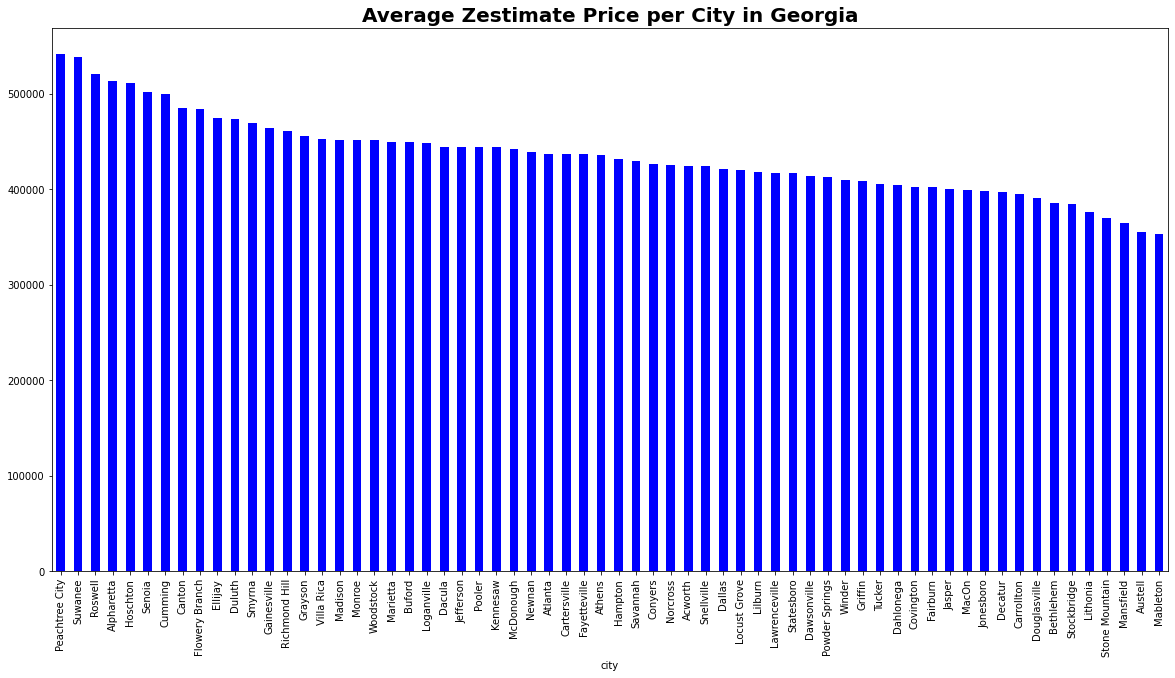

In [66]:
plt.figure(figsize = (20,10))
df_cities.groupby('city')['zestimate'].agg('mean').sort_values(ascending=False).plot.bar(color='blue')
plt.title("Average Zestimate Price per City in Georgia", fontweight="bold", size=20)

Text(0.5, 1.0, 'Average rentZestimate Price per City in Georgia')

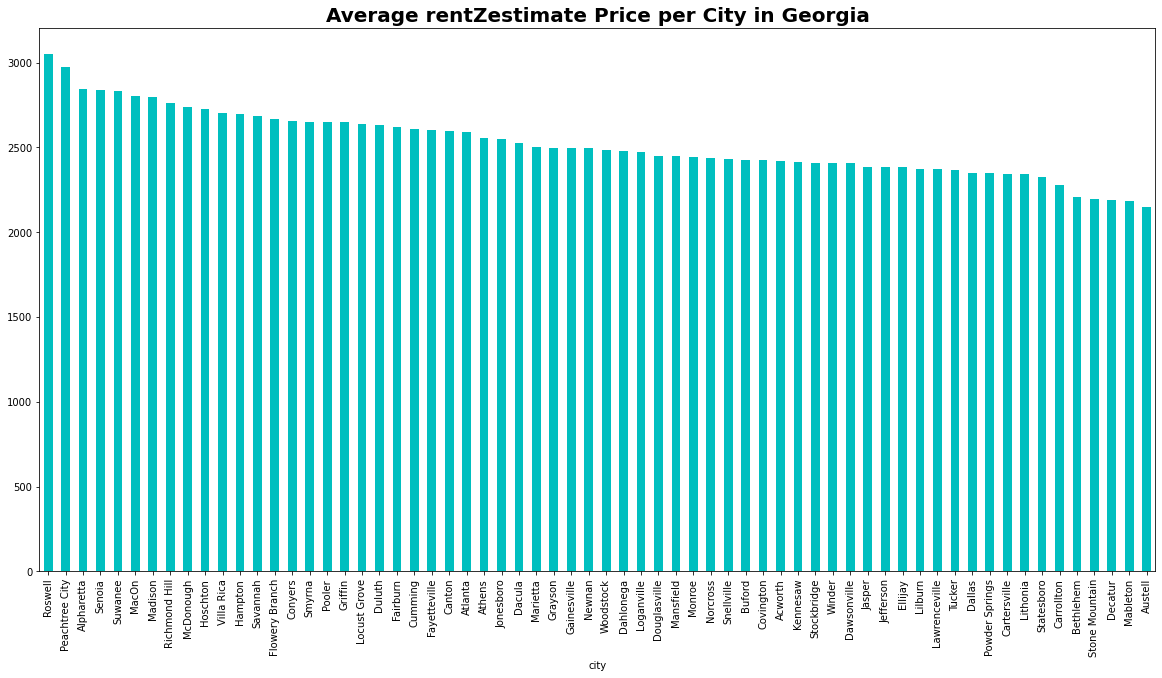

In [67]:
plt.figure(figsize = (20,10))
df_cities.groupby('city')['rentZestimate'].agg('mean').sort_values(ascending=False).plot.bar(color ='c')
plt.title("Average rentZestimate Price per City in Georgia", fontweight="bold", size=20)

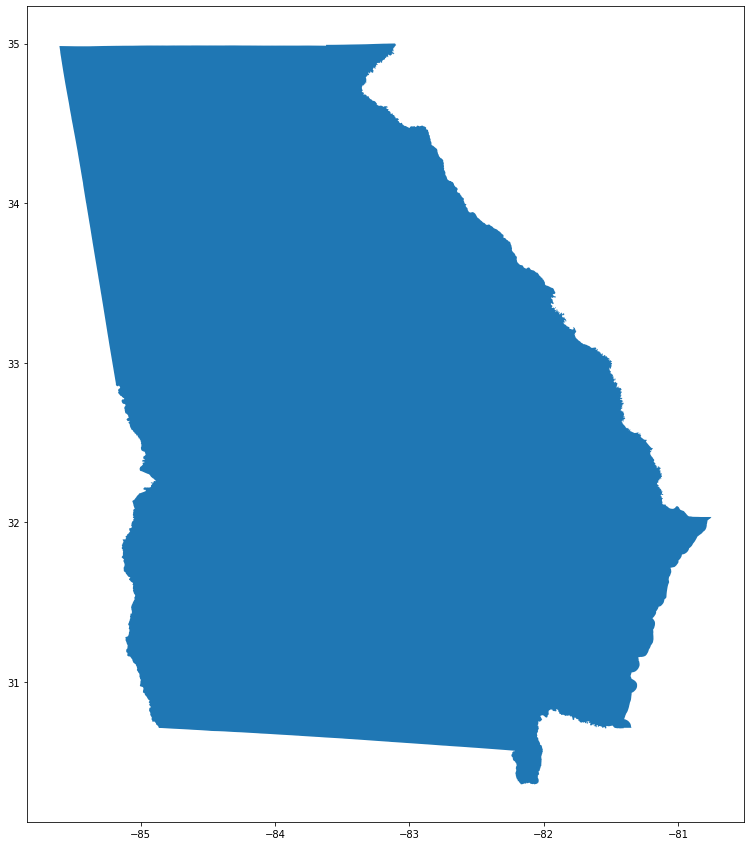

In [68]:
fig,ax = plt.subplots(figsize =(15,15))
georgia_map.plot(ax = ax)

In [69]:
df = completed_data[['zestimate', 'rentZestimate', 'address', 'city', 'zip','latitude', 'longitude']]
crs = {'init':'epsg:4326'}
df.head()

,zestimate,rentZestimate,address,city,zip,latitude,longitude
0,347870.00,2177.90,101 College Street,Kingsland,31548,30.804209,-81.653325
1,325200.00,2600.00,169 School House Creek Drive,Saint Marys,31558,30.767365,-81.588272
2,340500.00,1999.00,1621 Sandpiper Court,Saint Marys,31558,30.746731,-81.633995
3,312758.00,1999.00,346 Laurel Landing Boulevard,Kingsland,31548,30.791878,-81.676750
4,362160.13,1980.45,81 Ossabaw Way,Waverly,31565,31.104492,-81.604486


In [70]:
geometry = [Point(xy) for xy in zip (df['longitude'], df['latitude'])]
geometry[:3]

In [71]:
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,zestimate,rentZestimate,address,city,zip,latitude,longitude,geometry
0,347870.00,2177.90,101 College Street,Kingsland,31548,30.804209,-81.653325,POINT (-81.65332 30.80421)
1,325200.00,2600.00,169 School House Creek Drive,Saint Marys,31558,30.767365,-81.588272,POINT (-81.58827 30.76737)
2,340500.00,1999.00,1621 Sandpiper Court,Saint Marys,31558,30.746731,-81.633995,POINT (-81.63399 30.74673)
3,312758.00,1999.00,346 Laurel Landing Boulevard,Kingsland,31548,30.791878,-81.676750,POINT (-81.67675 30.79188)
4,362160.13,1980.45,81 Ossabaw Way,Waverly,31565,31.104492,-81.604486,POINT (-81.60449 31.10449)


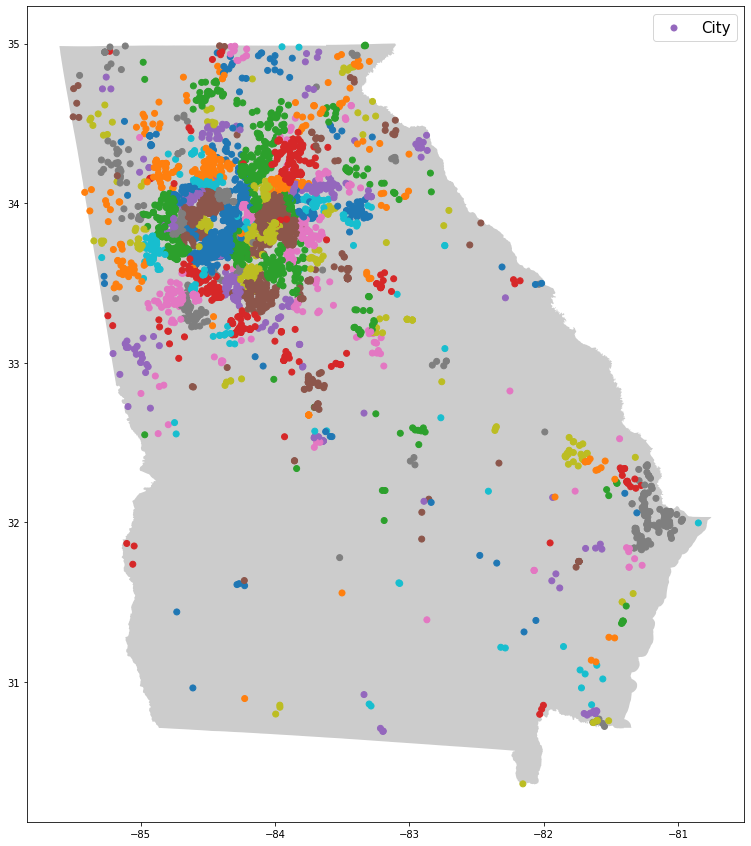

In [72]:
fig,ax = plt.subplots(figsize =(15,15))
georgia_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df.plot(column = 'city', ax=ax, categorical = True, legend = True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                         'fmt': "{:.0f}"}, label = "City")
plt.legend(prop = {'size': 15})

**Clustering GPS Coordinates**

In [73]:
x = completed_data.loc[:, ['zip', 'latitude', 'longitude']]
x.head(10)

,zip,latitude,longitude
0,31548,30.804209,-81.653325
1,31558,30.767365,-81.588272
2,31558,30.746731,-81.633995
3,31548,30.791878,-81.676750
4,31565,31.104492,-81.604486
5,31558,30.750340,-81.608505
6,31548,30.819548,-81.607118
7,31548,30.815933,-81.604103
8,31565,31.018468,-81.559863
9,31569,30.856803,-81.643137


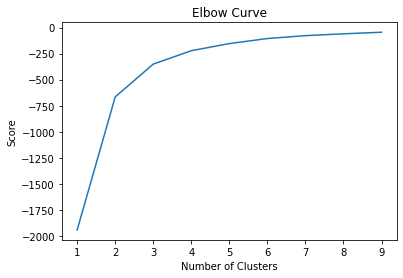

In [74]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = completed_data[['latitude']]
X_axis = completed_data[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [75]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')

# Compute k-means clustering.
kmeans.fit(x[x.columns[1:3]]) 

x['cluster_label'] = kmeans.fit_predict(x[x.columns[1:3]])

# Coordinates of cluster centers.
centers = kmeans.cluster_centers_ 
# Labels of each point
labels = kmeans.predict(x[x.columns[1:3]]) 
x.head(10)

,zip,latitude,longitude,cluster_label
0,31548,30.804209,-81.653325,1
1,31558,30.767365,-81.588272,1
2,31558,30.746731,-81.633995,1
3,31548,30.791878,-81.676750,1
4,31565,31.104492,-81.604486,1
5,31558,30.750340,-81.608505,1
6,31548,30.819548,-81.607118,1
7,31548,30.815933,-81.604103,1
8,31565,31.018468,-81.559863,1
9,31569,30.856803,-81.643137,1


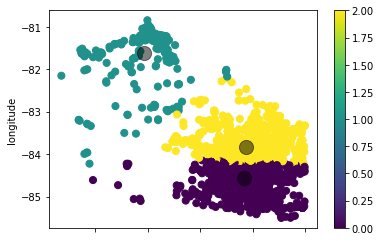

In [76]:
x.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [77]:
x = x[['zip','cluster_label']]
x.head()

,zip,cluster_label
0,31548,1
1,31558,1
2,31558,1
3,31548,1
4,31565,1


In [78]:
clustered_data = completed_data.merge(x, left_on='zip', right_on='zip')
clustered_data.head()

,rentZestimate,zestimate,price_y,PCT_CHG,bathrooms,bedrooms,yearBuilt,address,city,state,...,Prop_Cond_Grp_New,Prop_Cond_Grp_Remodeled,Prop_Cond_Grp_Resale,Two_Car_Garage_0,Two_Car_Garage_1,HasPool_0,HasPool_1,HasHardwood_0,HasHardwood_1,cluster_label
0,2177.9,347870.0,339900,0.11794,2,4,2020.0,101 College Street,Kingsland,Georgia,...,0,0,1,0,1,1,0,1,0,1
1,2177.9,347870.0,339900,0.11794,2,4,2020.0,101 College Street,Kingsland,Georgia,...,0,0,1,0,1,1,0,1,0,1
2,2177.9,347870.0,339900,0.11794,2,4,2020.0,101 College Street,Kingsland,Georgia,...,0,0,1,0,1,1,0,1,0,1
3,2177.9,347870.0,339900,0.11794,2,4,2020.0,101 College Street,Kingsland,Georgia,...,0,0,1,0,1,1,0,1,0,1
4,2177.9,347870.0,339900,0.11794,2,4,2020.0,101 College Street,Kingsland,Georgia,...,0,0,1,0,1,1,0,1,0,1


In [79]:
clustered_data.columns

Index(['rentZestimate', 'zestimate', 'price_y', 'PCT_CHG', 'bathrooms',
       'bedrooms', 'yearBuilt', 'address', 'city', 'state', 'zip', 'latitude',
       'longitude', 'livingArea', 'Lot_Size_SqFt', 'Price_SqFt', 'cap_rate',
       'Tot_Appl', 'Tot_Comm_Feat', 'Page_Views', 'Sch_Rat_Avg',
       'Sch_Dist_Avg', 'sch_cnt', 'Individuals_taxed', 'Income_per_return',
       'Cap_gain', 'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'violent_crime_total_rate',
       'property_crime_total_rate', 'other_crime_total_rate',
       'Prop_Cond_Grp_New', 'Prop_Cond_Grp_Remodeled', 'Prop_Cond_Grp_Resale',
       'Two_Car_Garage_0', 'Two_Car_Garage_1', 'HasPool_0', 'HasPool_1',
       'HasHardwood_0', 'HasHardwood_1', 'cluster_label'],
      dtype='object')

In [80]:
df_2 = clustered_data[['rentZestimate', 'address', 'city', 'zestimate', 'zip','latitude', 'longitude', 'cluster_label']]
crs = {'init':'epsg:4326'}
df_2.head()

,rentZestimate,address,city,zestimate,zip,latitude,longitude,cluster_label
0,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1
1,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1
2,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1
3,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1
4,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1


In [81]:

geometry = [Point(xy) for xy in zip (df_2['longitude'], df_2['latitude'])]
geometry[:3]

In [82]:
geo_df_2 = gpd.GeoDataFrame(df_2, crs = crs, geometry = geometry)
geo_df_2.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,rentZestimate,address,city,zestimate,zip,latitude,longitude,cluster_label,geometry
0,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1,POINT (-81.65332 30.80421)
1,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1,POINT (-81.65332 30.80421)
2,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1,POINT (-81.65332 30.80421)
3,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1,POINT (-81.65332 30.80421)
4,2177.9,101 College Street,Kingsland,347870.0,31548,30.804209,-81.653325,1,POINT (-81.65332 30.80421)


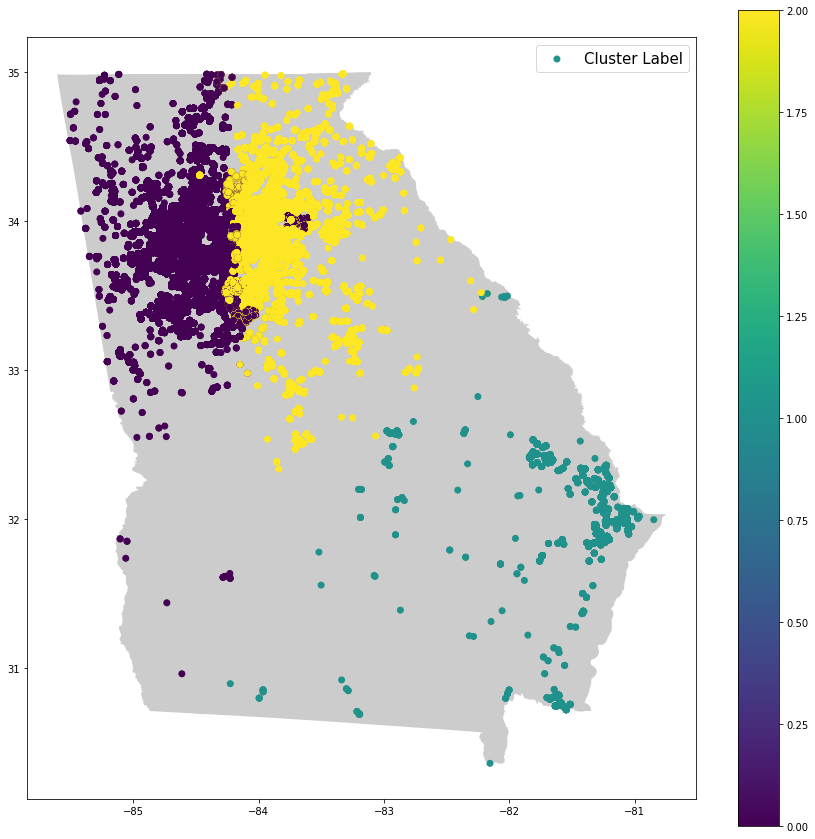

In [83]:
fig,ax = plt.subplots(figsize =(15,15))
georgia_map.plot(ax=ax, alpha = 0.4, color = 'grey')
geo_df_2.plot(column = 'cluster_label', ax=ax, legend = True, label = "Cluster Label")
plt.legend(prop = {'size': 15})

In [84]:
clustered_data.cluster_label.value_counts()

0    65155
2    57524
1     4226
Name: cluster_label, dtype: int64

In [85]:
df1 = clustered_data[clustered_data.cluster_label == 0]
df2 = clustered_data[clustered_data.cluster_label == 1]
df3 = clustered_data[clustered_data.cluster_label == 2]


**Random forest for clustered data**

In [86]:
df1_numerical = df1.select_dtypes(include = ('int64', 'float64'))
df1_numerical.columns

Index(['rentZestimate', 'zestimate', 'price_y', 'PCT_CHG', 'bathrooms',
       'bedrooms', 'yearBuilt', 'zip', 'latitude', 'longitude', 'livingArea',
       'Lot_Size_SqFt', 'Price_SqFt', 'cap_rate', 'Tot_Appl', 'Tot_Comm_Feat',
       'Page_Views', 'Sch_Rat_Avg', 'Sch_Dist_Avg', 'sch_cnt',
       'Individuals_taxed', 'Income_per_return', 'Cap_gain', 'Pension',
       'UE_claims', 'Social_security', 'SB_income', 'Student_loan_ded',
       'RE_taxes', 'PP_taxes', 'Child_credit', 'Earned_Inc_credit',
       'violent_crime_total_rate', 'property_crime_total_rate',
       'other_crime_total_rate', 'Prop_Cond_Grp_New',
       'Prop_Cond_Grp_Remodeled', 'Prop_Cond_Grp_Resale', 'Two_Car_Garage_0',
       'Two_Car_Garage_1', 'HasPool_0', 'HasPool_1', 'HasHardwood_0',
       'HasHardwood_1'],
      dtype='object')

In [87]:
df1_numerical_features = df1_numerical.drop(['rentZestimate', 'zestimate', 'price_y'], axis =1)
df1_numerical_features.columns


Index(['PCT_CHG', 'bathrooms', 'bedrooms', 'yearBuilt', 'zip', 'latitude',
       'longitude', 'livingArea', 'Lot_Size_SqFt', 'Price_SqFt', 'cap_rate',
       'Tot_Appl', 'Tot_Comm_Feat', 'Page_Views', 'Sch_Rat_Avg',
       'Sch_Dist_Avg', 'sch_cnt', 'Individuals_taxed', 'Income_per_return',
       'Cap_gain', 'Pension', 'UE_claims', 'Social_security', 'SB_income',
       'Student_loan_ded', 'RE_taxes', 'PP_taxes', 'Child_credit',
       'Earned_Inc_credit', 'violent_crime_total_rate',
       'property_crime_total_rate', 'other_crime_total_rate',
       'Prop_Cond_Grp_New', 'Prop_Cond_Grp_Remodeled', 'Prop_Cond_Grp_Resale',
       'Two_Car_Garage_0', 'Two_Car_Garage_1', 'HasPool_0', 'HasPool_1',
       'HasHardwood_0', 'HasHardwood_1'],
      dtype='object')

In [88]:
price = df1_numerical.zestimate

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df1_numerical_features, price, test_size=0.25, random_state=12)

In [90]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [91]:
rf.feature_importances_

array([5.79695790e-03, 3.26124848e-03, 2.73602211e-03, 1.18735059e-02,
       5.99942970e-03, 7.02353386e-03, 1.39561901e-02, 4.42427581e-01,
       7.94882108e-03, 3.05066237e-01, 6.36356698e-02, 1.22888439e-02,
       6.71071787e-03, 1.63556451e-02, 7.66060670e-03, 9.25376207e-03,
       2.75296327e-03, 5.44346014e-03, 3.23464372e-03, 3.78993480e-03,
       3.96761782e-03, 7.27093177e-03, 2.57870908e-03, 3.65516667e-03,
       3.13609904e-03, 4.34190555e-03, 7.78959736e-03, 3.30768733e-03,
       7.37943680e-03, 3.31597989e-03, 4.02221676e-03, 3.15443717e-03,
       1.54543409e-04, 8.06787479e-04, 1.12178006e-03, 8.06396872e-04,
       8.06773960e-04, 4.09016999e-05, 4.95354337e-05, 2.29301612e-03,
       2.78470489e-03])

Text(0.5, 0, 'Random Forest Feature Importance')

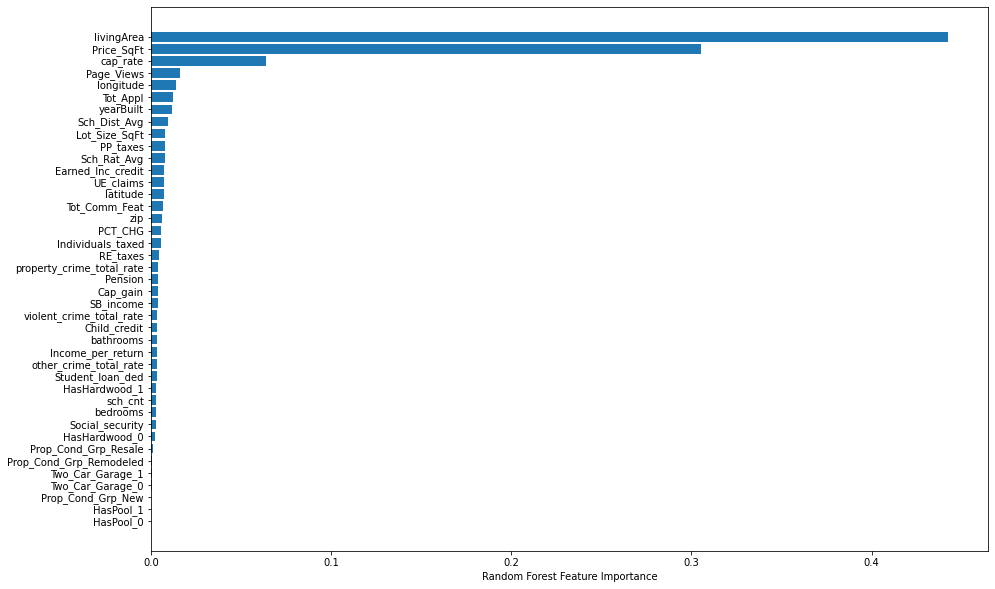

In [92]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(15, 10))
plt.barh(df1_numerical_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [93]:
map = folium.Map(location = [30.804209,	-81.653325], tiles='OpenStreetMap' , zoom_start = 9)
map